# Comparison of NSGA-II ranking algorithms

The performance of two multi-objective fast ranking algorithms are compared.  The first is the legacy fast rank sorting described in the seminal NSGA-II work by Deb et al.  The second is the Rank-based Non-Dominated Sort described by Bogdan Burlacu.

Bogdan Burlacu. 2022. _Rank-based Non-dominated Sorting_. arXiv.
      DOI:https://doi.org/10.48550/ARXIV.2203.13654

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import os
from functools import partial
from toolz import curry
from itertools import product
from tqdm import tqdm
from multiprocessing import Pool
#from multiprocessing.pool import ThreadPool as Pool

from leap_ec.representation import Representation
from leap_ec.ops import tournament_selection, clone, evaluate, pool, UniformCrossover
from leap_ec.real_rep.initializers import create_real_vector
from leap_ec.real_rep.ops import mutate_gaussian, apply_hard_bounds
from leap_ec.probe import print_individual

from leap_ec.multiobjective.nsga2 import generalized_nsga_2
from leap_ec.multiobjective.problems import SCHProblem
from leap_ec.multiobjective.ops import fast_nondominated_sort, rank_ordinal_sort

import multiobjective_defs

plt.rcParams['figure.figsize'] = [6.0, 3.0]
plt.rcParams['figure.dpi'] = 200



In [2]:
sch_problem = SCHProblem()
sch_representation = Representation(initialize=create_real_vector(bounds=[(-10, 10)]))

Time each of the three different ranking functions on the original NSGA-II population size and number of generations for a base level comparison.

In [3]:
POP_SIZE=50
MAX_GENERATIONS=100

pipeline = [
    tournament_selection,
    clone,
    UniformCrossover(p_swap=0.2),
    mutate_gaussian(std=0.5, expected_num_mutations=1),
    evaluate,
    pool(size=POP_SIZE)
]

t = time.time()
np.random.seed(multiobjective_defs.SEED)
random.seed(multiobjective_defs.SEED)
ros_pop = np.array(generalized_nsga_2(
    max_generations=MAX_GENERATIONS,
    pop_size=POP_SIZE,
    problem=sch_problem,
    representation=sch_representation,
    pipeline=pipeline,
    rank_func=rank_ordinal_sort
))
rank_ordinal_t = time.time() - t
print(f"Numpy Optimized Rank Ordinal (secs):\t{rank_ordinal_t:.3}")

t = time.time()
np.random.seed(multiobjective_defs.SEED)
random.seed(multiobjective_defs.SEED)
fnd_pop = np.array(generalized_nsga_2(
    max_generations=MAX_GENERATIONS,
    pop_size=POP_SIZE,
    problem=sch_problem,
    representation=sch_representation,
    pipeline=pipeline,
    rank_func=fast_nondominated_sort
))
fast_nondominated_t = time.time() - t
print(f"Fast Nondominated (secs):\t\t{fast_nondominated_t:.3}")
print(f"Speedup:\t\t\t\t{fast_nondominated_t/rank_ordinal_t:.3}")


Numpy Optimized Rank Ordinal (secs):	0.84
Fast Nondominated (secs):		17.6
Speedup:				21.0


Compare their outputs with increasing strictness: firstly producing the same set of fitnesses, then the same ranking, and lastly the same ordering.

In [4]:
ros_fitnesses = np.array([ind.fitness for ind in ros_pop])
fnd_fitnesses = np.array([ind.fitness for ind in fnd_pop])

ros_lex_pop = ros_pop[np.lexsort(ros_fitnesses.T, axis=0)]
fnd_lex_pop = fnd_pop[np.lexsort(fnd_fitnesses.T, axis=0)]

ros_lex_fitness = np.array([ind.fitness for ind in ros_lex_pop])
fnd_lex_fitness = np.array([ind.fitness for ind in fnd_lex_pop])

# Check that the lexicographically sorted fitnesses are identical
# I.e. check that regardless of original ordering, the same fitnesses were produced
np.testing.assert_array_equal(ros_lex_fitness, fnd_lex_fitness)

ros_ranks = np.array([ind.rank for ind in ros_lex_pop])
fnd_ranks = np.array([ind.rank for ind in fnd_lex_pop])

# Check that the final populations were ranked identically
np.testing.assert_array_equal(ros_ranks, fnd_ranks)

# Check that the original fitnesses are exactly the same order
np.testing.assert_array_equal(ros_fitnesses, fnd_fitnesses)


Compute a table of values for `rank_ordinal_sort` vs `fast_nondominated_sort` on the same random state.

In [5]:
ITERATIONS=5
POOL_SIZE=os.cpu_count() * 4

# We capture the results of the experiment for population size and algorithm with a number
# of iterations (runs).
bench_df = pd.DataFrame(
    {
        "pop_size": pop_size,
        "algorithm": algorithm,
        "iteration": iteration,
    } for algorithm, pop_size, iteration in product(
        ("rank_ordinal", "fast_nondominated"),
        np.logspace(1, 2.5, 7, dtype=np.int32),
        range(ITERATIONS)
    )
)


with Pool(processes=POOL_SIZE) as proc_pool:
    bench_df["time"] = list(tqdm(proc_pool.imap(
        multiobjective_defs.benchmark_wrapper,
        (tuple(row) for _, row in bench_df.iterrows())
    ), total=len(bench_df.index)))


100%|██████████| 70/70 [01:40<00:00,  1.43s/it]


In [8]:
bench_df

,pop_size,algorithm,iteration,time
0,10,rank_ordinal,0,0.137427
1,10,rank_ordinal,1,0.145594
2,10,rank_ordinal,2,0.143056
3,10,rank_ordinal,3,0.152685
4,10,rank_ordinal,4,0.162217
...,...,...,...,...
65,316,fast_nondominated,0,89.301010
66,316,fast_nondominated,1,89.608233
67,316,fast_nondominated,2,91.871696
68,316,fast_nondominated,3,90.079013


In [11]:
bench_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pop_size   70 non-null     int64  
 1   algorithm  70 non-null     object 
 2   iteration  70 non-null     int64  
 3   time       70 non-null     float64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.3+ KB


Graph of the time complexity for the two algorithms. Note that there are error bars around the lines, the error is just so small it isn't visible.

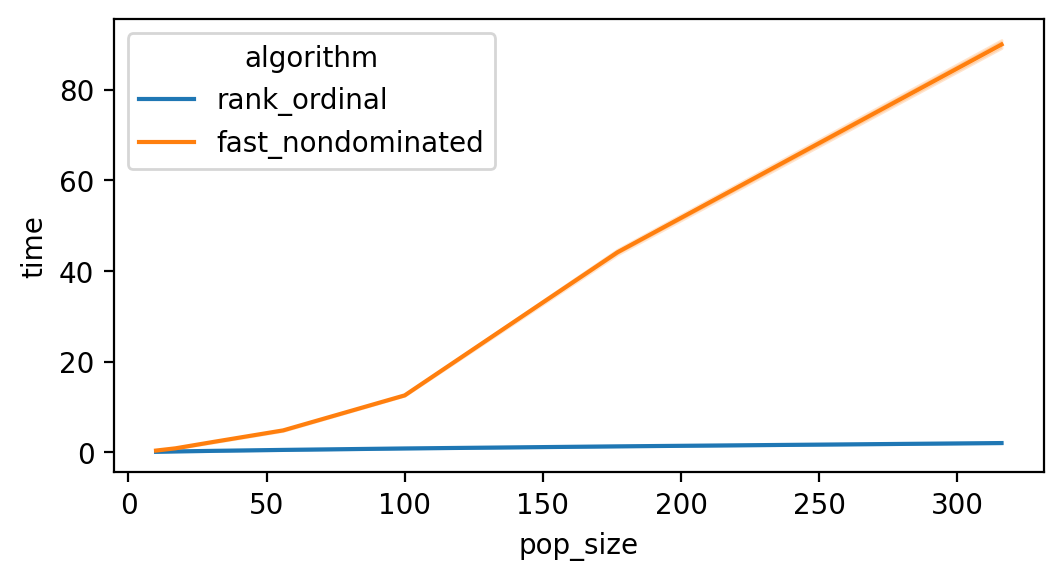

In [13]:
figure = sns.lineplot(data=bench_df, x='pop_size', y='time', hue='algorithm')
